In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('tracks_features_plus_popularity_1922_1979.xlsx', usecols="B:AA")
df = df[df['year'] >= 1923]
df.head()

/home/andrepalhares/.local/lib/python3.8/site-packages/pandas/io/excel/_base.py:1272: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  return self._reader.parse(


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,popularity
0,4MdlxZHzUi8fGvuXOtNVhb,Johnny B. Goode - Live,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],1,1,False,0.415,...,0.023,0.077100,0.9410,0.924,159.366,203407,4,1973,1973,6
1,576DmaRTiVhm3l00mpQwDm,Good Morning Little School Girl - Live,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],2,1,False,0.294,...,0.188,0.422000,0.9740,0.639,187.886,276968,4,1973,1973,4
2,3k3Q8IZ5oOqCUfOP2UPgpW,I'll Drown in My Tears,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],3,1,False,0.424,...,0.827,0.000021,0.0742,0.390,95.799,285360,3,1973,1973,2
3,1fuxmrrP5JKu0eeHi1c7Ug,When You Got A Good Friend,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],4,1,False,0.504,...,0.831,0.030000,0.1680,0.787,146.244,218453,4,1973,1973,3
4,6yziyzrBhA2mFApoJKAill,Be Careful with a Fool,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],5,1,False,0.293,...,0.494,0.022300,0.2080,0.730,206.991,315133,3,1973,1973,4


In [3]:
def obter_decada(linha):
    ano = str(linha['year'])
    return int(ano[:3] + "0")

df['decade'] = df.apply (lambda x: obter_decada(x), axis=1)

In [4]:
df = df[df['decade'] != "00"]
df[df['popularity'] >= 10].groupby('decade').size()

decade
1920     129
1930     210
1940     174
1950     940
1960    3547
1970    8517
dtype: int64

### UtilIzando o KNN para classificar músicas do período anterior
##### Músicas entre 1922 e 1979

In [5]:
df_1920 = df[df['decade'] == 1920].sort_values(by=['popularity'], ascending=False)[:129]
df_1930 = df[df['decade'] == 1930].sort_values(by=['popularity'], ascending=False)[:129]
df_1940 = df[df['decade'] == 1940].sort_values(by=['popularity'], ascending=False)[:129]
df_1950 = df[df['decade'] == 1950].sort_values(by=['popularity'], ascending=False)[:129]
df_1960 = df[df['decade'] == 1960].sort_values(by=['popularity'], ascending=False)[:129]
df_1970 = df[df['decade'] == 1970].sort_values(by=['popularity'], ascending=False)[:129]

df_1922_a_1980 = pd.concat([df_1920, df_1930, df_1940, df_1950, df_1960, df_1970], ignore_index=True, sort=False)

df_1922_a_1980.groupby('decade').size()

decade
1920    129
1930    129
1940    129
1950    129
1960    129
1970    129
dtype: int64

In [6]:
X = df_1922_a_1980[['danceability', 'energy', 'key', 'loudness', 'mode', 
        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
        'valence', 'tempo', 'duration_ms', 'time_signature']]
y = df_1922_a_1980['decade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

#### Gerando o melhor valor para k

In [8]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
params = {'n_neighbors': np.arange(10, 200, 5)}
knn_gscv = GridSearchCV(knn, params)
knn_gscv.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195])})

In [9]:
best_k = knn_gscv.best_params_['n_neighbors']
print('Melhor resultado: ', best_k)

Melhor resultado:  35


#### Classificação

In [10]:
classifier = KNeighborsClassifier(
    n_neighbors=best_k, 
    p=6, # quantidade de décadas a serem testadas
    metric='euclidean')

In [11]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=35, p=6)

In [12]:
y_pred = classifier.predict(X_test)

In [13]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[23  5  3  0  1  0]
 [ 9 24  3  1  1  1]
 [ 7 12 18  3  2  1]
 [ 6  8 12  5  6  3]
 [ 5 11  5  3 10  7]
 [ 0  3  1  2  4 28]]


In [14]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
print('f1_score: ', f1_score(y_test, y_pred, average='weighted'))

f1_score:  0.4369990072935252


In [15]:
print('accuracy_score:', accuracy_score(y_test, y_pred))

accuracy_score: 0.463519313304721


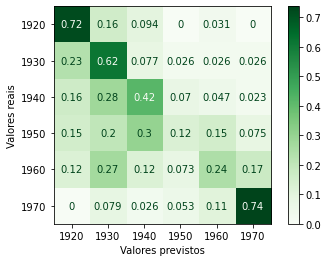

In [16]:
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=[1920, 1930, 1940, 1950, 1960, 1970],
                             cmap=plt.cm.Greens,
                             normalize='true')
plt.xlabel('Valores previstos')
plt.ylabel('Valores reais')
plt.show()